# Import libraries

In [1]:
import numpy as np
from numpy import log
import pandas as pd
import geopandas as gpd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For visualising data on interactive maps. Supports Image, Video, GeoJSON, TopoJSON overlays
import folium 

from bokeh.plotting import figure, show
from bokeh.tile_providers import get_provider, Vendors # tile provider is the underlying map
from bokeh.io import reset_output, output_notebook, save # to display plots inside Jupyter

reset_output()
output_notebook()

Loading BokehJS ...

# Load & clean datasets

In [4]:
ZONES = pd.read_feather('./Data/TaxiZones.feather')
ZONES.tail()

,LocationID,Borough,Zone,service_zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,None
264,265,Unknown,None,None


In [5]:
FILE_PATH = f"./Data/$LICENSE$_$YEAR$/$LICENSE$_tripdata_$YEAR$-$MONTH$.feather" 
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [6]:
def feather_to_df(license, year, month):
    file_path = FILE_PATH.replace("$YEAR$", year).replace("$MONTH$", month).replace("$LICENSE$", license)
    return pd.read_feather(file_path)

In [26]:
def logify(x): 
    return log(x) if x else 0

## Yellow taxi 2019

In [63]:
df_yellow_2019 = pd.DataFrame()

In [68]:
df_months = {month: pd.DataFrame() for month in MONTHS}
for i, month in enumerate(MONTHS):
    df_this_month = df_months[month]
    df_this_month['a'] = pd.Series(data=[i for i in range(i)])
    df_months[month] = df_this_month
    


/Users/danielye/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [73]:
df_months['May']

,a
0,0
1,1
2,2
3,3


In [77]:
%%time

YEAR = '2019'
LICENSE = 'yellow'

df_months = dict()
found_na = dict()

def check_na(attr_name, df):
    result = df[attr_name].isna().any()
    if result: found_na[attr_name] = True
    return result

for i, month in enumerate(MONTHS):
    
    month_num = i + 1
    month_str = f"{month_num:02}"
    print('\n\n' + LICENSE + YEAR + '-' + month_str)
    print('\t reading feather...')
    %time df_this_month = feather_to_df(LICENSE, YEAR, month_str)
    df_this_month.drop(
        ['index', 'VendorID', 'store_and_fwd_flag', 'mta_tax', 'improvement_surcharge'], 
        axis=1, 
        inplace=True
    )
    
    time_cols = ['tpep_pickup_datetime','tpep_dropoff_datetime']
    for time_col in time_cols:    
        check_na(time_col, df_this_month)
        print("t\ casting datetime")
        %time df_this_month[time_col] = pd.to_datetime(df_this_month[time_col], 
                                                                  yearfirst=True,
                                                                  errors='raise')
    print('\t categorising ratecode')
    %time df_this_month.RatecodeID = (df_this_month.RatecodeID
                                      .astype('category')
                                      .cat.rename_categories({
                                          1: 'Standard', 
                                          2: 'JFK', 
                                          3: 'Newark',
                                          4: 'Nassau/Westchester',
                                          5: 'Negotiated', 
                                          6: 'Group', 
                                          99: 'Unknown'
                                      }))
    df_this_month = df_this_month.rename(columns={'RatecodeID': 'Ratecode'})
    
    check_na('PULocationID', df_this_month)
    check_na('DOLocationID', df_this_month)
    df_this_month[['PULocationID', 'DOLocationID']] = df_this_month[['PULocationID', 'DOLocationID']].astype('category')
    
    check_na('DOLocationID', df_this_month)
    df_this_month['payment_type'] = df_this_month['payment_type'].astype('category').cat.rename_categories({
        1: 'Credit Card',
        2: 'Cash',
        3: 'No charge', 
        4: 'Dispute',
        5: 'Unknown',
        6: 'Voided Trip'
    })
    
    df_months[month] = df_this_month

yellow201901
CPU times: user 4.07 s, sys: 1.7 s, total: 5.77 s
Wall time: 4.99 s
yellow201902
CPU times: user 4.64 s, sys: 3.62 s, total: 8.25 s
Wall time: 8.32 s
yellow201903
CPU times: user 4.52 s, sys: 3.6 s, total: 8.11 s
Wall time: 9.37 s
yellow201904
CPU times: user 4.33 s, sys: 3.42 s, total: 7.75 s
Wall time: 9.09 s
yellow201905
CPU times: user 4.49 s, sys: 3.56 s, total: 8.05 s
Wall time: 9.68 s
yellow201906
CPU times: user 4.32 s, sys: 3.21 s, total: 7.53 s
Wall time: 8.98 s
yellow201907
CPU times: user 3.82 s, sys: 2.53 s, total: 6.35 s
Wall time: 6.54 s
yellow201908
CPU times: user 4.24 s, sys: 3.02 s, total: 7.25 s
Wall time: 7.57 s
yellow201909
CPU times: user 4.6 s, sys: 3.35 s, total: 7.95 s
Wall time: 8.42 s
yellow201910
CPU times: user 4.54 s, sys: 3.17 s, total: 7.71 s
Wall time: 8.09 s
yellow201911
CPU times: user 4.5 s, sys: 3.6 s, total: 8.1 s
Wall time: 7.97 s
yellow201912
CPU times: user 4.72 s, sys: 3.31 s, total: 8.04 s
Wall time: 8.28 s
CPU times: user 1min 5

In [61]:
df_yellow_19_feb

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,Ratecode,PULocationID,DOLocationID,payment_type,fare_amount,extra,tip_amount,tolls_amount,total_amount,congestion_surcharge
0,2019-02-01 00:59:04,2019-02-01 01:07:27,1,2.1,Standard,48,234,Credit Card,9.0,0.5,2.0,0.0,12.3,0.0
1,2019-02-01 00:33:09,2019-02-01 01:03:58,1,9.8,Standard,230,93,Cash,32.0,0.5,0.0,0.0,33.3,0.0
2,2019-02-01 00:09:03,2019-02-01 00:09:16,1,0.0,Standard,145,145,Cash,2.5,0.5,0.0,0.0,3.8,0.0
3,2019-02-01 00:45:38,2019-02-01 00:51:10,1,0.8,Standard,95,95,Cash,5.5,0.5,0.0,0.0,6.8,0.0
4,2019-02-01 00:25:30,2019-02-01 00:28:14,1,0.8,Standard,140,263,Cash,5.0,0.5,0.0,0.0,6.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019370,2019-02-28 23:29:08,2019-02-28 23:29:11,1,0.0,Standard,193,193,Credit Card,0.0,0.0,0.0,0.0,0.0,0.0
7019371,2019-02-28 22:48:47,2019-02-28 23:50:19,1,0.0,Standard,141,193,Cash,0.0,0.0,0.0,0.0,0.0,2.5
7019372,2019-02-28 23:41:23,2019-02-28 23:42:23,1,0.0,Standard,264,264,Credit Card,0.0,0.0,0.0,0.0,0.0,0.0
7019373,2019-02-28 23:12:52,2019-02-28 23:14:16,1,0.0,Standard,264,193,Credit Card,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
df_yellow_19_feb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7019375 entries, 0 to 7019374
Data columns (total 14 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        int64         
 3   trip_distance          float64       
 4   Ratecode               category      
 5   PULocationID           category      
 6   DOLocationID           category      
 7   payment_type           category      
 8   fare_amount            float64       
 9   extra                  float64       
 10  tip_amount             float64       
 11  tolls_amount           float64       
 12  total_amount           float64       
 13  congestion_surcharge   float64       
dtypes: category(4), datetime64[ns](2), float64(7), int64(1)
memory usage: 575.7 MB


### Check that passenger counts make sense: MAY WANT TO REDISTRIBUTE 0

In [33]:
df_yellow_19_feb['passenger_count'] = df_yellow_19_feb['passenger_count'].astype('int')

In [36]:
df_yellow_19_feb.passenger_count.unique()

array([1, 2, 6, 0, 5, 3, 4, 9, 7, 8])

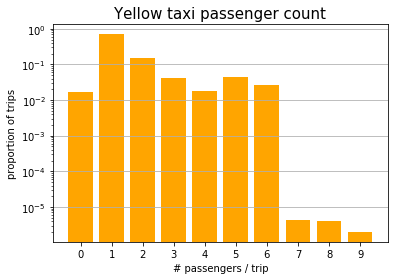

In [45]:
figure, axes = plt.subplots()
plt.grid(which='major', axis='y')
max_passengers = df_yellow_19_feb.passenger_count.unique().max()
counts, bins, patches = plt.hist(df_yellow_19_feb.passenger_count, 
                                 density=True, 
                                 log=True, 
                                 bins=range(max_passengers+2), 
                                 align='left', 
                                 rwidth=0.8,
                                 color='orange',
                                 label=[str(i) for i in range(max_passengers)])
plt.title("Yellow taxi passenger count", fontsize=15)
plt.xlabel('# passengers / trip')
plt.ylabel('proportion of trips')
plt.xticks(range(max_passengers+1))
plt.show()

### Check for extraneous Ratecodes

In [46]:
ratecodes = df_yellow_19_feb.groupby('RatecodeID').agg(num_trips=('RatecodeID', 'count'))

In [47]:
ratecodes = ratecodes.reset_index()

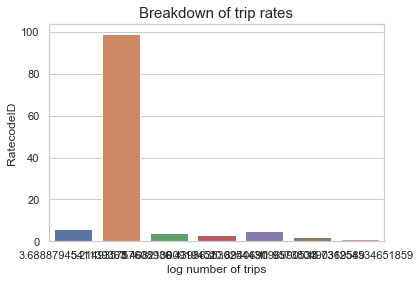

In [48]:
sns.set(style='whitegrid')
sns.barplot(x=ratecodes['num_trips'].apply(logify), y=ratecodes['RatecodeID'])
plt.xlabel('log number of trips')
plt.title('Breakdown of trip rates', fontsize=15)
plt.show()

### Breakdown of payment type

In [32]:
payment = df_yellow_jan_19.groupby('payment_type').agg(n_trips=('payment_type', 'count'))

In [33]:
payment = payment.reset_index()

In [34]:
payment

,payment_type,n_trips
0,Credit Card,5486027
1,Cash,2137415
2,No charge,33186
3,Dispute,11164


Text(0.5, 1.0, 'Payment types')

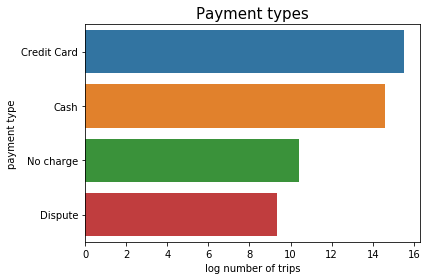

In [35]:
sns.barplot(x=payment['n_trips'].apply(logify), y=payment['payment_type'])
plt.xlabel("log number of trips")
plt.ylabel("payment type")
plt.title("Payment types", fontsize=15)